In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
should_skip = True

In [3]:
#@title Install libraries
if not should_skip:
  !pip install -U -qq git+https://github.com/huggingface/diffusers.git
  !pip install -qq accelerate transformers ftfy
  !pip install -q gpustat gdown
  !pip install -q pytorch_lightning
  !pip install -q supervision roboflow

In [4]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TVF
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
import sys

# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py#L175-L182
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from pytorch_lightning import seed_everything

import supervision as sv
from roboflow import Roboflow

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
if not should_skip:
    #@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
    train_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
    ]
    test_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
        ## You can add additional images here
    ]
#@title Download
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

if not should_skip:
    for save_path,urls in [("./my_concept",train_urls),("./my_concept_test",test_urls)]:
      images = list(filter(None,[download_image(url) for url in urls]))
      if not os.path.exists(save_path):
        os.mkdir(save_path)
      [image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]


if not should_skip:
    !gdown --id 1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
    mask_path="./my_concept_gt"
    !mkdir $mask_path/

    with open("my_concept_gt.zip","r") as f:
        pass
    !unzip -o my_concept_gt.zip

In [6]:
# %cd /content/
# sys.path.append("/content/slime-experiments/")

In [7]:
# !rm -rf slime-experiments/
# !git clone https://github.com/andrew-healey/slime-experiments
# !cd slime-experiments && git rev-parse --short HEAD

In [8]:
from slime.slime import SLiME
from slime.data.single_class import BinarySegmentationDataset,SegmentationDataModule
from slime.data.rf_coco import SemanticSegmentationDataset

In [9]:
# Set the seed
seed_everything(42)

Seed set to 42


42

In [40]:
#@title Download Roboflow dataset
rf = Roboflow(api_key="PPa4WEink4MOydk4Rbzb")
project = rf.workspace("andrew-healey-qy1qe").project("dogs-yvwts")
dataset = project.version(3).download("coco-segmentation")

rf_train_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=True
)
rf_train_dataset.classes[0] = "null"

rf_test_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
    force_masks=True
)
rf_test_dataset.classes[0] = "null"

print(rf_test_dataset.classes)

loading Roboflow workspace...
loading Roboflow project...
Exporting format coco-segmentation in progress : 85.0%
Version export complete for coco-segmentation format



Extracting Dataset Version Zip to Dogs-3 in coco-segmentation:: 100%|██████████| 13/13 [00:00<00:00, 5142.50it/s]


['null', 'dog']


In [41]:
use_roboflow = True #@param {type:"boolean"}

if use_roboflow:
    train_dataset = SemanticSegmentationDataset(
        rf_train_dataset,
    )
    test_dataset = SemanticSegmentationDataset(
        rf_test_dataset,
    )
else:
    train_dataset = BinarySegmentationDataset(
        data_root="my_concept",
        mask_root="my_concept_gt",
    )
    test_dataset = BinarySegmentationDataset(
        data_root="my_concept_test",
        mask_root=None
    )

data_module = SegmentationDataModule(
    train_dataset,
    test_dataset,
    iters_per_epoch=100,
    batch_size=1,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


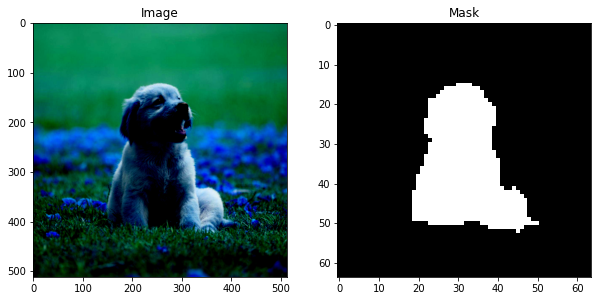

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a random image/mask pair from the train set
random_index = np.random.randint(len(train_dataset))
row = train_dataset[random_index]
img = row["pixel_values"]
mask = row["gt_masks_oh"]

# Plot the image and mask in subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image
axs[0].imshow(img.permute(1, 2, 0))
axs[0].set_title('Image')

# Plot the mask
axs[1].imshow(mask[...,1], cmap='gray')
axs[1].set_title('Mask')

plt.show()


In [43]:
slime = SLiME(
    use_self_attn=True,
    classes=1
).cuda()

It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.


In [44]:
from pytorch_lightning import Trainer

trainer = Trainer(
    default_root_dir="run",
    limit_train_batches=1.0,
    num_sanity_val_steps=0,
    max_epochs=1,
    enable_checkpointing=False,
)

trainer.fit(slime, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type            | Params
-----------------------------------------------------------
0 | sd                     | StableDiffusion | 900 M 
1 | cross_layer_multiplier | Multiplier      | 32    
2 | self_layer_multiplier  | Multiplier      | 32    
3 | cross_map_multiplier   | Multiplier      | 4     
4 | pred_map_multiplier    | Multiplier      | 4     
  | other params           | n/a             | 2.0 K 
-----------------------------------------------------------
2.1 K     Trainable params
900 M     Non-trainable params
900 M     Total params
3,600.306 Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

pred 0.08 0.08 ce loss 0.7 mse loss 0.33
pred -0.97 0.05 ce loss 0.77 mse loss 2.3
pred -0.77 0.04 ce loss 0.51 mse loss 1.04
pred -0.98 0.04 ce loss 0.77 mse loss 2.31
pred -0.78 0.04 ce loss 0.67 mse loss 1.58
pred -0.5 0.03 ce loss 0.56 mse loss 0.6
pred -0.57 0.03 ce loss 0.55 mse loss 0.7
pred -0.85 0.03 ce loss 0.68 mse loss 1.74
pred -0.99 0.03 ce loss 0.77 mse loss 2.34
pred -0.91 0.03 ce loss 0.5 mse loss 1.31
pred -0.95 0.03 ce loss 0.69 mse loss 2.0
pred -0.89 0.03 ce loss 0.75 mse loss 2.06
pred -0.68 0.03 ce loss 0.53 mse loss 0.87
pred -0.64 0.03 ce loss 0.72 mse loss 1.46
pred -0.51 0.03 ce loss 0.66 mse loss 1.03
pred -0.39 0.03 ce loss 0.67 mse loss 0.82
pred -0.29 0.04 ce loss 0.69 mse loss 0.81
pred -0.18 0.04 ce loss 0.64 mse loss 0.26
pred -0.31 0.04 ce loss 0.6 mse loss 0.37
pred -0.6 0.04 ce loss 0.67 mse loss 1.2
pred -0.85 0.04 ce loss 0.75 mse loss 1.95
pred -0.95 0.04 ce loss 0.76 mse loss 2.21
pred -0.9 0.05 ce loss 0.68 mse loss 1.85
pred -0.79 0.06 ce loss

`Trainer.fit` stopped: `max_epochs=1` reached.


pred -5.42 15.47 ce loss 0.13 mse loss 23.77


In [45]:
slime.cuda(); 0

0

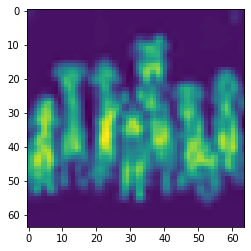

In [46]:
import matplotlib.pyplot as plt
plt.imshow(slime.latest_preds[-1].swapaxes(1,2).reshape((-1,slime.text_tokens,64,64))[0,1])

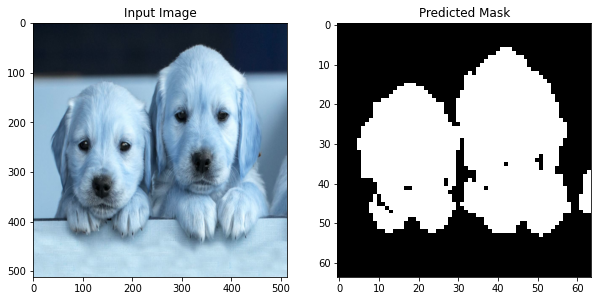

In [49]:
#@title Infer on test set
out_mask = None
in_img = None
loader = data_module.test_dataloader()
for i,batch in enumerate(loader):
  in_img = (batch["pixel_values"].numpy() + 1.0)/2# * 127.5
  out_mask = slime.predict_step(batch,i).cpu().numpy()

  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  # Display the input image
  axs[0].imshow(in_img[0].transpose(1, 2, 0))
  axs[0].set_title('Input Image')

  # Display the predicted mask
  axs[1].imshow(out_mask[0].reshape((64,64)), cmap='gray')
  axs[1].set_title('Predicted Mask')

  plt.show()
  break


# Experiments with spectral analysis

i.e. use attn map, or transposed attn map, or symmetrized map?
(unchecked) maybe use cosine similarity of embeds


In [48]:
raise 1

TypeError: exceptions must derive from BaseException

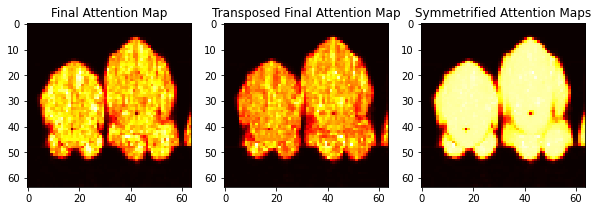

In [100]:
# visualize self-attn maps

self_attn_maps = slime.latest_selfs

# pick a random token to visualize

batch_num = 0
layer_num = 0

mask = out_mask[batch_num].astype(bool)==1

layer = self_attn_maps[layer_num]
num_tokens = layer.shape[1]
token_num = random.randint(0, num_tokens - 1)

im_dims = int(math.sqrt(layer.shape[-1]))

raw_map = layer[batch_num]

# make attn map cols sum to 1
attn_map = raw_map / raw_map.sum(axis=1)
attn_map_t = raw_map.T / raw_map.sum(axis=0)
attn_map_sym = (attn_map + attn_map_t) / 2

final_attn_map = attn_map[mask].mean(axis=0).reshape(im_dims, im_dims).copy()
final_attn_t_map = attn_map_t[mask].mean(axis=0).reshape(im_dims, im_dims).copy()
final_attn_sym_map = attn_map_sym[mask].mean(axis=0).reshape(im_dims, im_dims).copy()

plt.figure(figsize=(10, 5))

# Plotting the final attention map
plt.subplot(1, 3, 1)
plt.imshow(final_attn_map, cmap='hot', interpolation='nearest')
plt.title('Final Attention Map')

# Plotting the transposed final attention map
plt.subplot(1, 3, 2)
plt.imshow(final_attn_t_map, cmap='hot', interpolation='nearest')
plt.title('Transposed Final Attention Map')

# Plotting the average of the two
plt.subplot(1, 3, 3)
plt.imshow(final_attn_sym_map, cmap='hot', interpolation='nearest')
plt.title('Symmetrified Attention Maps')


# plt.colorbar()

plt.show()


(4096, 4096) (4096,)


divide by zero encountered in log


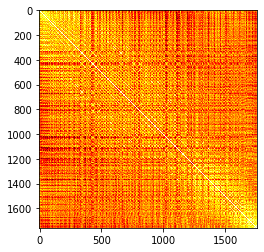

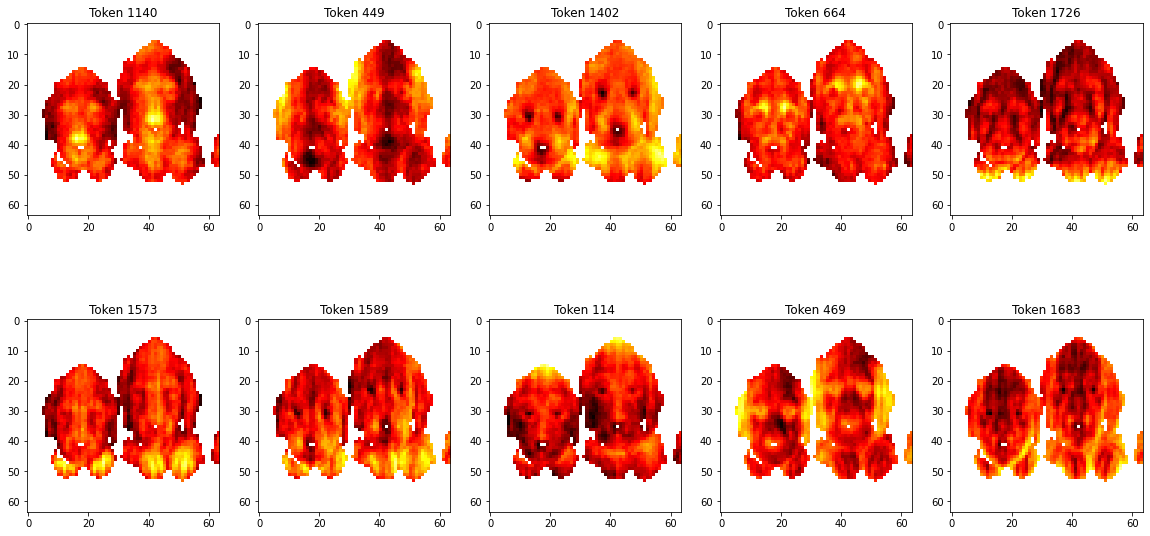

In [104]:
eps = 1e-6
print(attn_map_sym.shape,mask.shape)
chosen_attn_map = attn_map_sym[:,mask][mask,:]

copied_attn_map = chosen_attn_map.copy()
copied_attn_map[torch.arange(copied_attn_map.shape[0]), torch.arange(copied_attn_map.shape[0])] = 0
plt.imshow(np.log(np.abs(copied_attn_map)), cmap='hot', interpolation='nearest')
plt.show()

def demaskify(masked):
    full_map = np.zeros((len(mask)))
    full_map[mask] = masked
    return full_map.reshape(im_dims, im_dims)


fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    token_num = random.randint(0, len(chosen_attn_map) - 1)
    map = chosen_attn_map[token_num]
    map[token_num] = map.max()
    axs[i//5, i%5].imshow(demaskify(np.log(map)), cmap='hot', interpolation='nearest')
    axs[i//5, i%5].set_title(f'Token {token_num}')
plt.show()


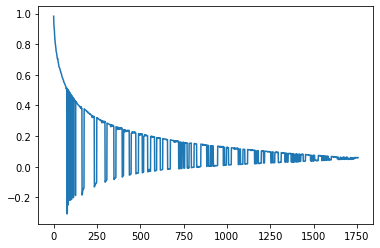

In [105]:
eigenvals, eigenvectors = np.linalg.eig(chosen_attn_map)
plt.plot(eigenvals.real)

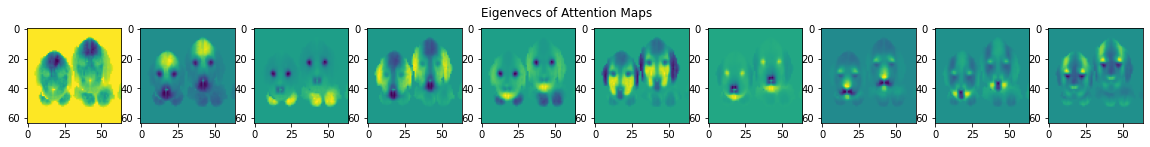

In [108]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
plt.suptitle('Eigenvecs of Attention Maps')
for i in range(10):
    eigenvec = eigenvectors[:,i].real
    axs[i].imshow(demaskify(eigenvec))
plt.show()


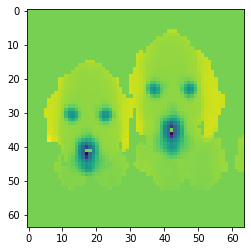

In [110]:
#@title Normalized cut
# see https://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf
A = torch.from_numpy(chosen_attn_map)
B = torch.diag(torch.sum(A, dim=1))

num_eigenvectors = 10

gen_eigenvals, gen_eigenvectors = torch.lobpcg((B-A).cuda(), B=B.cuda(),k=num_eigenvectors,largest=False)
second_eigenvector = gen_eigenvectors[:,1].real.cpu()
plt.imshow(demaskify(second_eigenvector.numpy()))

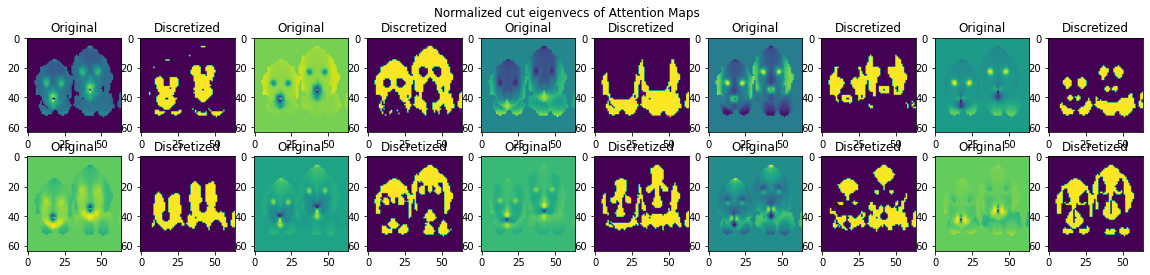

In [112]:
fig, axs = plt.subplots(2, num_eigenvectors, figsize=(20, 4))
plt.suptitle('Normalized cut eigenvecs of Attention Maps')
for i in range(num_eigenvectors):
    gen_eigenvec = gen_eigenvectors[:,i].real.cpu()
    # Plot the original eigenvector
    axs[i//5, 2*(i%5)].imshow(demaskify(gen_eigenvec))
    axs[i//5, 2*(i%5)].set_title('Original')
    # Discretize the eigenvector
    disc_gen_eigenvec = (gen_eigenvec > gen_eigenvec.mean()).float()
    # Plot the discretized eigenvector
    axs[i//5, 2*(i%5)+1].imshow(demaskify(disc_gen_eigenvec))
    axs[i//5, 2*(i%5)+1].set_title('Discretized')
plt.show()


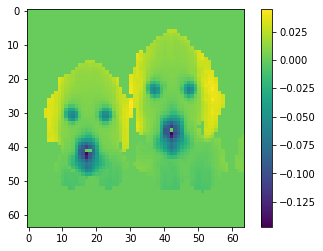

In [116]:
from scipy.linalg import eigh
# Provided utility function by the user
def second_smallest_eigenvector(A, D):
    # get the second smallest eigenvector from affinity matrix
    _, eigenvectors = eigh(D-A, D, subset_by_index=[1,2])
    eigenvec = np.copy(eigenvectors[:, 0])
    second_smallest_vec = eigenvectors[:, 0]
    return eigenvec, second_smallest_vec


util_eigenvec, second_smallest_vec = second_smallest_eigenvector(chosen_attn_map, np.diag(chosen_attn_map.sum(axis=1)))
plt.imshow(demaskify(util_eigenvec))
plt.colorbar()